In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray

2024-04-11 14:03:44.013251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 14:03:44.013354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 14:03:44.132470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
# Define image parameters
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 30
BATCH_SIZE = 1
IMAGE_SIZE = [256, 256]

In [5]:
# Function to parse TFRecord files
def read_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

# Load dataset from image files
def load_dataset(files):
    dataset = tf.data.Dataset.list_files(files)
    dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
# Define paths for TrainA, TrainB, TestA, and TestB
trainA_files = "/kaggle/input/monet2photo/trainA/*.jpg"
trainB_files = "/kaggle/input/monet2photo/trainB/*.jpg"
testA_files = "/kaggle/input/monet2photo/testA/*.jpg"
testB_files = "/kaggle/input/monet2photo/testB/*.jpg"

In [7]:
# Load datasets
trainA_images = load_dataset(trainA_files).batch(BATCH_SIZE)
trainB_images = load_dataset(trainB_files).batch(BATCH_SIZE)
testA_images = load_dataset(testA_files).batch(BATCH_SIZE)
testB_images = load_dataset(testB_files).batch(BATCH_SIZE)

In [8]:
# Generator model
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)

In [9]:
# Discriminator model
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)
    norm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,  kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=inp, outputs=last)

In [10]:
# CycleGan class
class CycleGan(keras.Model):
    def __init__(
        self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [11]:
# Loss functions
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [12]:
# Initialize models
monet_generator = Generator() 
photo_generator = Generator() 

monet_discriminator = Discriminator() 
photo_discriminator = Discriminator()

In [13]:
monet_generator.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [14]:
photo_generator.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      3,072 │ input_layer_16[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 16, 16,    │  2,099,200 │ sequential_17[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 8, 8, 512) │  4,196,352 │ sequential_18[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_20       │ (None, 4, 4, 512) │  4,196,352 │ sequential_19[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_21       │ (None, 2, 2, 512) │  4,196,352 │ sequential_20[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 1, 1, 512) │  4,196,352 │ sequential_21[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 2, 2, 512) │  4,196,352 │ sequential_22[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 2, 2,      │          0 │ sequential_23[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_24       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 4, 4,      │          0 │ sequential_24[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_25       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 8, 8,      │          0 │ sequential_25[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_26       │ (None, 16, 16,    │  8,390,656 │ concatenate_9[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 16, 16,    │          0 │ sequential_26[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [15]:
monet_discriminator.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 31, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
photo_discriminator.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_33 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_34 (Sequential)      │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_35 (Sequential)      │ (None, 32, 32, 256)    │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 34, 34, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 31, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [17]:
# Compile the CycleGan model
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    m_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [18]:
# Train the CycleGan model
hist=cycle_gan_model.fit(
    tf.data.Dataset.zip((trainA_images, trainB_images)),
    epochs=EPOCHS,
)

Epoch 1/30


I0000 00:00:1712844343.100976      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1072/1072 ━━━━━━━━━━━━━━━━━━━━ 259s 147ms/step - monet_disc_loss: 0.6717 - monet_gen_loss: 3.9038 - photo_disc_loss: 0.6800 - photo_gen_loss: 3.9061 - loss: 0.0000e+00
Epoch 2/30
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 158s 147ms/step - monet_disc_loss: 0.6492 - monet_gen_loss: 2.9620 - photo_disc_loss: 0.6560 - photo_gen_loss: 2.9806 - loss: 0.0000e+00
Epoch 3/30
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 158s 147ms/step - monet_disc_loss: 0.6381 - monet_gen_loss: 2.7934 - photo_disc_loss: 0.6379 - photo_gen_loss: 2.8329 - loss: 0.0000e+00
Epoch 4/30
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 158s 147ms/step - monet_disc_loss: 0.6462 - monet_gen_loss: 2.6491 - photo_disc_loss: 0.6344 - photo_gen_loss: 2.7090 - loss: 0.0000e+00
Epoch 5/30
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 158s 147ms/step - monet_disc_loss: 0.6458 - monet_gen_loss: 2.6328 - photo_disc_loss: 0.6162 - photo_gen_loss: 2.7418 - loss: 0.0000e+00
Epoch 6/30
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 158s 147ms/step - monet_disc_loss: 0.6505 - monet_gen_loss: 2.5635 - photo

Mean Monet Generator Loss on Test Data: 0.5000595
Mean Photo Generator Loss on Test Data: 0.9671809
Mean Monet Discriminator Loss on Test Data: 0.7811934
Mean Photo Discriminator Loss on Test Data: 0.72919244
Mean PSNR on Test Data: 28.8529744027891
Mean SSIM on Test Data: 0.853322330420377


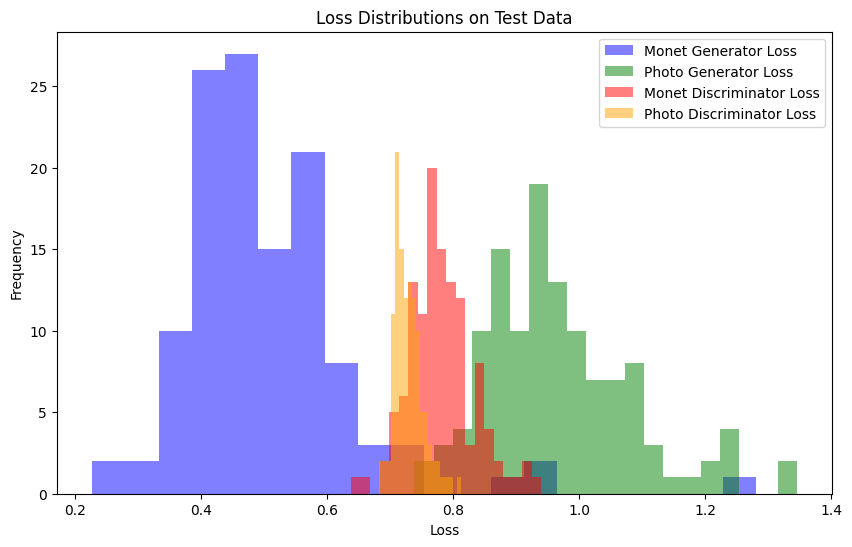

In [19]:
def calculate_ssim(real_images, generated_images):
    ssim_values = []
    for real, generated in zip(real_images, generated_images):
        # Convert images to grayscale
        real_gray = rgb2gray(real)
        generated_gray = rgb2gray(generated)
        # Compute SSIM
        ssim_value = ssim(real_gray, generated_gray, data_range=generated_gray.max() - generated_gray.min())
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

def evaluate_model(model, test_data):
    monet_gen_losses = []
    photo_gen_losses = []
    monet_disc_losses = []
    photo_disc_losses = []
    psnr_values = []
    ssim_values = []
    
    for batch_data in test_data:
        fake_monet = model.m_gen(batch_data, training=False)
        cycled_photo = model.p_gen(fake_monet, training=False)
        fake_photo = model.p_gen(fake_monet, training=False)
        cycled_monet = model.m_gen(fake_photo, training=False)
        
        # Compute loss values
        monet_gen_loss = model.gen_loss_fn(model.m_disc(fake_monet, training=False))
        photo_gen_loss = model.gen_loss_fn(model.p_disc(fake_photo, training=False))
        monet_disc_loss = model.disc_loss_fn(model.m_disc(batch_data, training=False), model.m_disc(fake_monet, training=False))
        photo_disc_loss = model.disc_loss_fn(model.p_disc(fake_monet, training=False), model.p_disc(fake_photo, training=False))
        
        # Compute PSNR
        for real, generated in zip(batch_data, fake_monet):
            psnr_value = psnr((real.numpy() + 1) / 2, (generated.numpy() + 1) / 2, data_range=1)
            psnr_values.append(psnr_value)
        
        # Compute SSIM
        ssim_value = calculate_ssim(batch_data, fake_monet)
        ssim_values.append(ssim_value)
        
        monet_gen_losses.append(monet_gen_loss.numpy())
        photo_gen_losses.append(photo_gen_loss.numpy())
        monet_disc_losses.append(monet_disc_loss.numpy())
        photo_disc_losses.append(photo_disc_loss.numpy())

    # Calculate mean losses
    mean_monet_gen_loss = np.mean(monet_gen_losses)
    mean_photo_gen_loss = np.mean(photo_gen_losses)
    mean_monet_disc_loss = np.mean(monet_disc_losses)
    mean_photo_disc_loss = np.mean(photo_disc_losses)
    mean_psnr = np.mean(psnr_values)
    mean_ssim = np.mean(ssim_values)
    
    print("Mean Monet Generator Loss on Test Data:", mean_monet_gen_loss)
    print("Mean Photo Generator Loss on Test Data:", mean_photo_gen_loss)
    print("Mean Monet Discriminator Loss on Test Data:", mean_monet_disc_loss)
    print("Mean Photo Discriminator Loss on Test Data:", mean_photo_disc_loss)
    print("Mean PSNR on Test Data:", mean_psnr)
    print("Mean SSIM on Test Data:", mean_ssim)
    
    # Visualize the results 
    plt.figure(figsize=(10, 6))
    plt.hist(monet_gen_losses, bins=20, alpha=0.5, color='blue', label='Monet Generator Loss')
    plt.hist(photo_gen_losses, bins=20, alpha=0.5, color='green', label='Photo Generator Loss')
    plt.hist(monet_disc_losses, bins=20, alpha=0.5, color='red', label='Monet Discriminator Loss')
    plt.hist(photo_disc_losses, bins=20, alpha=0.5, color='orange', label='Photo Discriminator Loss')
    plt.title('Loss Distributions on Test Data')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# Evaluate the model
evaluate_model(cycle_gan_model, testA_images)

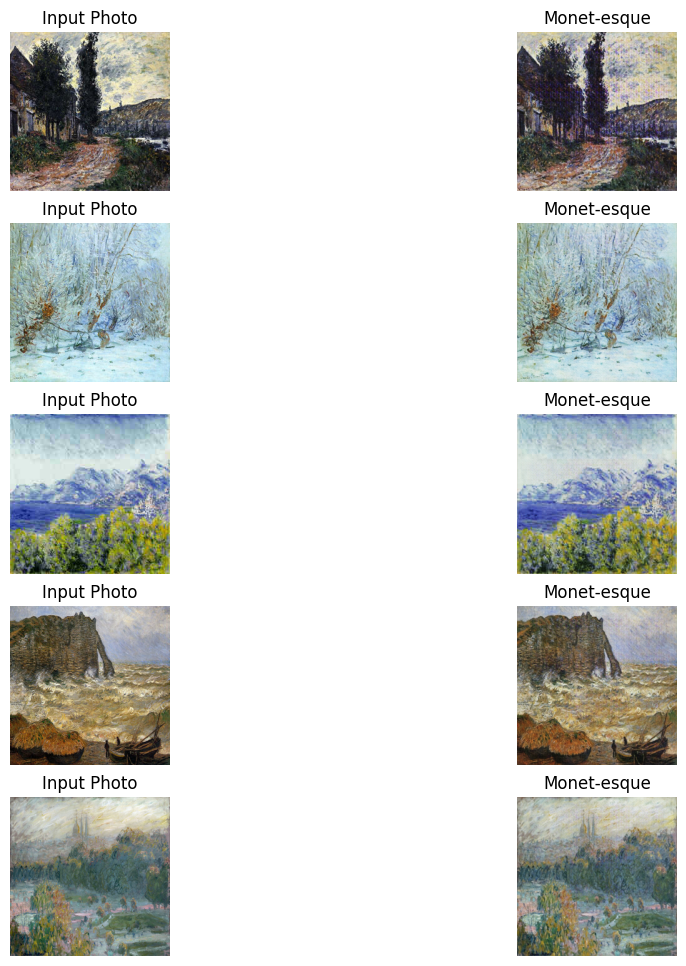

In [20]:
# Visualize Monet Photos
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(testA_images.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

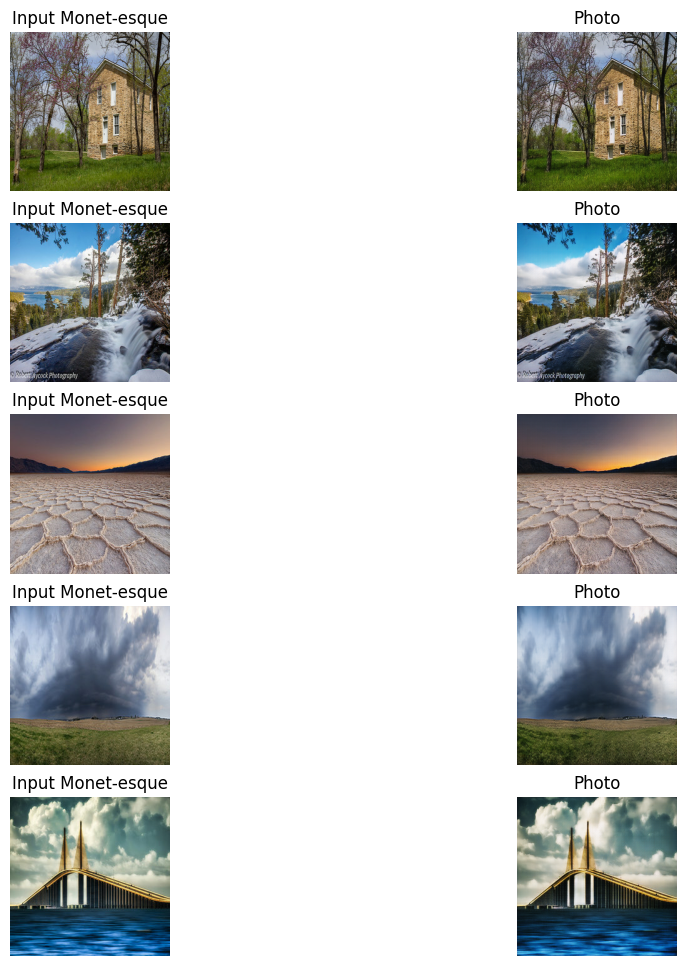

In [21]:
# Visualize Photo Photos
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(testB_images.take(5)):
    prediction = photo_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Monet-esque")
    ax[i, 1].set_title("Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()